In [1]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [2]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [3]:
segments_df

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,nb_activities_last_30d
0,24674235,4831255939,10944546,Champs-Élysées,VirtualRide,653,653,6623.100,82.3,202.8,0.0,4.6,0,161.2,170.0,18:46:25,2021-02-22,6
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,VirtualRide,424,424,1882.500,77.3,201.2,3.8,47.8,0,157.9,164.0,18:19:40,2021-02-22,6
2,22501195,4818094466,10944546,Villenave-Technopole,Ride,789,789,5100.500,NaN,108.0,0.5,6.4,0,169.0,184.0,14:39:32,2021-02-20,6
3,3566434,4818094466,10944546,Col du Chateau d'eau,Ride,217,217,1190.370,NaN,141.8,2.1,7.3,0,170.7,183.0,14:40:47,2021-02-20,6
4,20598228,4818094466,10944546,Col du chateau d'eau court,Ride,151,151,745.400,NaN,165.4,2.8,5.5,0,177.5,183.0,14:42:02,2021-02-20,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,17782861,1597380847,10944546,RadarStadeMartillac,Ride,40,40,303.400,NaN,189.4,1.4,1.6,0,176.8,182.0,12:42:52,2018-05-26,0
1936,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,Ride,90,90,541.374,NaN,158.9,2.0,5.5,0,183.6,188.0,12:47:30,2018-05-26,0
1937,3752963,1597380847,10944546,Imitationberg,Ride,141,141,872.000,NaN,82.3,-0.0,5.6,0,168.2,184.0,12:53:34,2018-05-26,0
1938,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,Ride,226,226,1431.800,NaN,84.4,-0.6,21.7,0,155.2,186.0,12:56:14,2018-05-26,0


In [4]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [5]:
dates = segments_df['calendar_day'].unique()

In [6]:
dates = dates.tolist()

In [7]:
ratio_train_test = len(dates) * 0.1
ratio_train_test

20.0

In [8]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [9]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(169, 19)

In [10]:
test_set_index = test_set.index
test_set_index

Int64Index([  67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
            ...
            1593, 1594, 1595, 1596, 1679, 1699, 1778, 1779, 1780, 1781],
           dtype='int64', length=169)

In [11]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,nb_activities_last_30d,calendar_day
0,24674235,4831255939,10944546,Champs-Élysées,VirtualRide,653,653,6623.100,82.3,202.8,0.0,4.6,0,161.2,170.0,18:46:25,2021-02-22,6,0532021
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,VirtualRide,424,424,1882.500,77.3,201.2,3.8,47.8,0,157.9,164.0,18:19:40,2021-02-22,6,0532021
2,22501195,4818094466,10944546,Villenave-Technopole,Ride,789,789,5100.500,NaN,108.0,0.5,6.4,0,169.0,184.0,14:39:32,2021-02-20,6,0512021
3,3566434,4818094466,10944546,Col du Chateau d'eau,Ride,217,217,1190.370,NaN,141.8,2.1,7.3,0,170.7,183.0,14:40:47,2021-02-20,6,0512021
4,20598228,4818094466,10944546,Col du chateau d'eau court,Ride,151,151,745.400,NaN,165.4,2.8,5.5,0,177.5,183.0,14:42:02,2021-02-20,6,0512021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,17782861,1597380847,10944546,RadarStadeMartillac,Ride,40,40,303.400,NaN,189.4,1.4,1.6,0,176.8,182.0,12:42:52,2018-05-26,0,1462018
1936,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,Ride,90,90,541.374,NaN,158.9,2.0,5.5,0,183.6,188.0,12:47:30,2018-05-26,0,1462018
1937,3752963,1597380847,10944546,Imitationberg,Ride,141,141,872.000,NaN,82.3,-0.0,5.6,0,168.2,184.0,12:53:34,2018-05-26,0,1462018
1938,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,Ride,226,226,1431.800,NaN,84.4,-0.6,21.7,0,155.2,186.0,12:56:14,2018-05-26,0,1462018


In [12]:
1771/1940

0.9128865979381443

## Scaler Data ??

## Model

In [13]:
columns = ['elapsed_time','distance','average_grade','nb_activities_last_30d']
# columns = ['elapsed_time','distance','average_grade']
train_set = train_set[columns]
test_set = test_set[columns]

In [14]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1771,)
(1771, 3)
(169,)
(169, 3)


**Log Label**

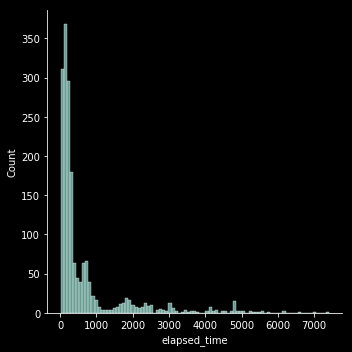

In [15]:
sns.displot(y_train)

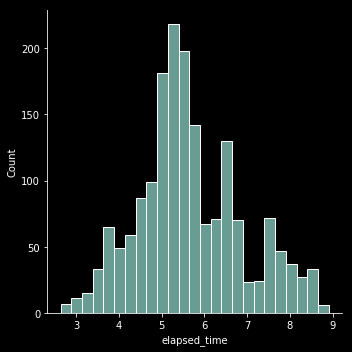

In [16]:
sns.displot(np.log(y_train))

In [17]:
y_train_log = np.log(y_train)

#### Algos

In [18]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [19]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [20]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 668.911910901204
mape_reg : 0.8778943539585223
rmse_reg: 2902.9032316175158


In [21]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 77.30976821402827
mape_xgb: 0.1903329455917461
rmse_xgb: 144.13157927995928


In [22]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb],
    'MAPE':[mape_naive,mape_reg,mape_xgb],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg'])
comparaison_df.sort_values(by=['MAPE'])

,MAE,MAPE,RMSE
xgbreg,77.309768,0.190333,144.131579
naive,202.259702,0.372339,464.705005
linreg,668.911911,0.877894,2902.903232


### Prediction Alpe d'huez

In [23]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

,distance,altitude_gain,average_grade,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


**Activities last 30d**

In [24]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [25]:
nb_activities_last_30d = len(activities_df[activities_df['start_date'].between(start_date,end_date)])
nb_activities_last_30d

8

In [26]:
segments_alpe_df['nb_activities_last_30d'] = nb_activities_last_30d
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,nb_activities_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",8
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",8
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",8
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",8


In [27]:
datas = segments_alpe_df[['distance','average_grade','nb_activities_last_30d']]
# datas = segments_alpe_df[['distance','average_grade']]
datas

,distance,average_grade,nb_activities_last_30d
0,270.55,-0.30,8
1,422.22,1.03,8
2,427.89,-1.29,8
3,12615.51,8.43,8


In [28]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

relativedelta(hours=+1, minutes=+14, seconds=+52.1186)

In [29]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

relativedelta(hours=+1, minutes=+12, seconds=+52.6191)

In [30]:
elapsed_time_naive

relativedelta(minutes=+38, seconds=+32.1867)

In [31]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [32]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [33]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [34]:
distance = segments_alpe_df['distance'].sum()
distance

13736.17

In [35]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','strava'])
comparaison_pred_df

Prediction 0h38m32sec
Prediction 1h14m52sec
Prediction 1h12m52sec


,Prediction,Mean_speed(km/h)
naive,0h38m32sec,21.386773
linreg,1h14m52sec,11.008213
xgbreg,1h12m52sec,11.309057
strava,0h31m39s,26.040133
